<a href="https://colab.research.google.com/github/android-kunjapppan/Classifier-to-detector/blob/master/Object_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification vs. Object detection

* IMage Classification:
    * One Image in
    * One class Label out

* Object Detection on the other hand, not only tells us what is in the image(i.e., Class Label) but also where in the image the object is.. via bounding box(x,y).
    * Input one image
    * Obtain multiple bounding boxes and class labels as output.

* Any object detection alg(regardless of traditional computer vision or state-of-the-art Deep learning), follows the same pattern.
    * **Input**: An image.
    * **Output**: Three values including:
        * 1: A **list of bounding boxes**, or the x,y coordinates of each object in the image.
        * 2: The **Class Label** associated with each of the boundimg boxes.
        * 3: The **probability/confidence score** associated with each bounding box and class label. 

# Converting an CNN Image Classifier into an object detectot.

* We'll be borrowing elements from HOG + Linear SVM to convert any deep Learning etwork image classifier into an Object Detector.

    * The first ingredient from HOG + Linear SVM is to use image pyramids.
        * Utilizing an image pyramid allows us to find objects in images at different scales of an image.
    
    * The second ingredient is sliding windows.
        * As the name suggests, a sliding window is a fixed-size rectangle tht slides from left-to-right and top-to-bottom within an image.
        * At each stop of window we would:
            * 1: Extract the ROI
            * 2: Pass it through our classifier
            * 3: Obtain the output predictions.
    
    * combined with image pyramids, sliding windows allow us to localize objects at different locations and multiple scales of the input image.


    * The final key ingredient is Non- max Suppression(NMS).
        * we will use NMS to suppress weak, overlapping bounding boxes in favour of higher confidence predictions.


  

# Algorithm:

* 1: Input an image.

* 2: Construct an image pyramid.

* 3: For each scale of the image pyramid, run a sliding window.
    * 3a: For each step of sliding window, extract ROI.
    * 3b: Take the ROI and pass it through our CNN originally trained for image classification.
    * 3c: Examine the probability of the top class label of the CNN and if meets the minimum confidence, record (1) the class label and (2) the location of the sliding window.

* 4: Apply class-wise non-maxima suppression to the bounding boxes.

* 5: Return results to calling function.

 

In [1]:
import imutils

def sliding_windows(image,step,window_size):
  for y in range(0, image.shape[1] - window_size[1],step):
    for x in range(0, image.shape[0] - window_size[0],step):
      yield (x,y, image[y:y + window_size[1],x:x + window_size[0]])

def image_pyramid(image,scale=1.25, minsize=(224,224)):
  yield image

  while True:
    width = int(image.shape[1]/scale)
    image= imutils.resize(image,width=width)

    if (image.shape[0] < minsize[1] or image.shape[1] < minsize[0]):
      break
    
    yield image

In [2]:
import keras
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression


import numpy as np
import time 
import cv2

Using TensorFlow backend.


In [31]:
width = 600
scale=1.5
window_step=16
ROI_size = (250,250)
input_size = (224,224)
visualize =1

In [4]:
model = ResNet50(weights='imagenet', include_top = True)

In [29]:
orig = cv2.imread('/content/drive/My Drive/hummingbird.jpg')
print(orig.shape)
orig = imutils.resize(orig, width = width)
print(orig.shape)
(H,W)=orig.shape[:2]

(394, 700, 3)
(337, 600, 3)


In [7]:
from google.colab.patches import cv2_imshow

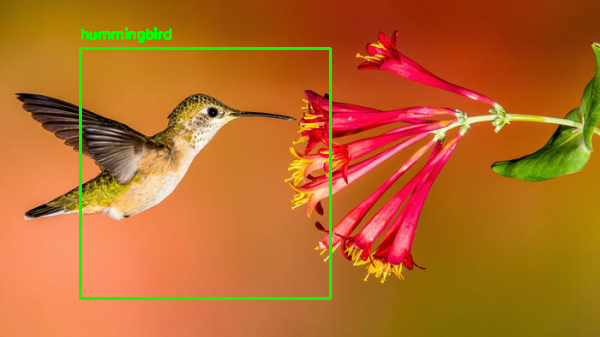

In [32]:
pyramid=image_pyramid(orig,scale=scale,minsize=ROI_size)

ROIS=[]
locations=[]  # stores the x,y




for image in pyramid:
  scale = W/float(image.shape[1])

  for (x,y,roiOrig) in sliding_windows(image,window_step,ROI_size):
    x = int(x*scale)
    y = int(y*scale)
    w = int(ROI_size[0]*scale)
    h = int(ROI_size[1]*scale)

    # take the ROI and preprocess it to classify the region using Keras, tensorflow
    roi = cv2.resize(roiOrig,input_size)
    roi = img_to_array(roi)
    roi = preprocess_input(roi)


    ROIS.append(roi)
    locations.append((x,y,x+w,y+h))


    """if(visualize>0):
      clone = orig.copy()
      cv2.rectangle(clone,(x,y),(x+w,y+h),(0,255,0),2)


      cv2_imshow(clone)
      cv2_imshow(roiOrig)
      #cv2.waitKey(0)"""


ROIS=np.array(ROIS,dtype='float32')

preds= model.predict(ROIS)
preds = imagenet_utils.decode_predictions(preds,top=1)

labels={}


#loop over predictions
for (i,p) in enumerate(preds):
  (imagenetID,label,prob)=p[0]

  if(prob>=0.95):
    box=locations[i]

    L= labels.get(label,[])
    L.append((box,prob))
    labels[label]=L


# Loop over the labels for each of the detected objects in the image:
for label in labels.keys():
  clone= orig.copy()

  for (box,prob) in labels[label]:
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone,(startX,startY),(endX,endY),(0,255,0),2)


  #cv2_imshow(clone)
  clone = orig.copy()

  #Extract the bouding boxes and associated predictions probabilities, then apply non-maxima suppression

  boxes= np.array([p[0] for p in labels[label]])
  proba= np.array([p[1] for p in labels[label]])

  boxes = non_max_suppression(boxes,proba)

  for ( startX, startY, endX, endY) in boxes:
    cv2.rectangle(clone,(startX,startY),(endX,endY),(0,255,0),2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(clone,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0,255,0),2)

  cv2_imshow(clone)
  cv2.waitKey(0) 










